In [1]:
from pykrx import stock
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False
stock_list = pd.DataFrame({'종목코드':stock.get_market_ticker_list(market="ALL")})
stock_list['종목명'] = stock_list['종목코드'].map(lambda x: stock.get_market_ticker_name(x))


In [2]:
# stock_list[stock_list['종목명'].str.contains('중공')]

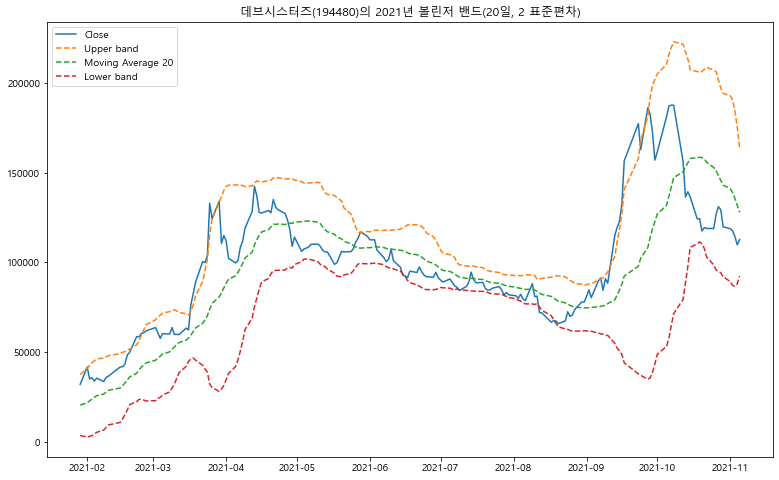

In [221]:
name = '데브시스터즈'
fromdate = str(20210101)
todate = str(20211107)

ticker = stock_list.loc[stock_list['종목명']==name, '종목코드']
df = stock.get_market_ohlcv_by_date(fromdate=fromdate, todate=todate, ticker=ticker)


df = df.rename(columns={'시가':'Open', '고가':'High', '저가':'Low', '종가':'Close', '거래량':'Volume'})
df['ma20'] = df['Close'].rolling(window=20).mean() # 20일 이동평균
df['stddev'] = df['Close'].rolling(window=20).std() # 20일 이동표준편차
df['upper'] = df['ma20'] + 2*df['stddev'] # 상단밴드
df['lower'] = df['ma20'] - 2*df['stddev'] # 하단밴드
df = df[19:] # 20일 이동평균을 구했기 때문에 20번째 행부터 값이 들어가 있음


plt.figure(figsize=(13, 8))
plt.plot(df.index, df['Close'], label='Close')
plt.plot(df.index, df['upper'], linestyle='dashed', label='Upper band')
plt.plot(df.index, df['ma20'], linestyle='dashed', label='Moving Average 20')
plt.plot(df.index, df['lower'], linestyle='dashed', label='Lower band')
plt.title(f'{name}({int(ticker.values)})의 2021년 볼린저 밴드(20일, 2 표준편차)')
plt.legend(loc='best');
plt.show()

In [222]:
df['volatility'] = (df['upper'] - df['lower'])/2
df.head()

,Open,High,Low,Close,Volume,ma20,stddev,upper,lower,volatility
날짜,,,,,,,,,,
2021-01-29,33500,34600,29100,32200,1195861,20715.0,8463.499028,37641.998055,3788.001945,16926.998055
2021-02-01,33700,41850,33150,41850,2200135,22062.5,9562.933857,41188.367713,2936.632287,19125.867713
2021-02-02,41100,41800,34800,35200,1236892,23040.0,9867.298462,42774.596925,3305.403075,19734.596925
2021-02-03,35100,37350,33000,35900,411098,24035.0,10120.134959,44275.269917,3794.730083,20240.269917
2021-02-04,35800,35900,33700,34000,187919,24930.0,10172.827584,45275.655168,4584.344832,20345.655168


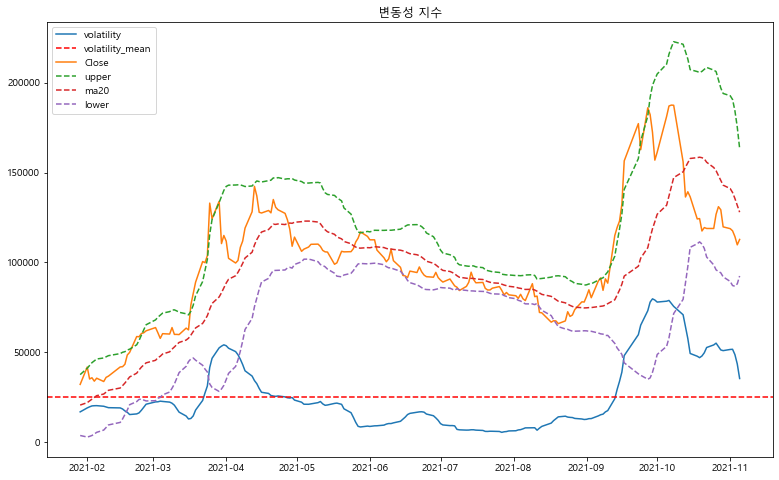

In [223]:
plt.figure(figsize=(13, 8))
plt.plot(df['volatility'])
plt.axhline(df['volatility'].mean(), color='red', linestyle='--')
plt.plot(df.index, df['Close'], label='Close')
plt.plot(df.index, df['upper'], linestyle='dashed', label='Upper band')
plt.plot(df.index, df['ma20'], linestyle='dashed', label='Moving Average 20')
plt.plot(df.index, df['lower'], linestyle='dashed', label='Lower band')
plt.legend(['volatility', 'volatility_mean', 'Close', 'upper', 'ma20', 'lower'])
plt.title('변동성 지수')
plt.show()

In [227]:
df1 = df.copy().loc[:,('Close','ma20','volatility')]
df1.insert(0, column='f_close', value=0)
df1.insert(0, column='f_ma20', value=0)
df1.insert(0, column='f_vol', value=0)
df1.insert(0, column='ff_vol', value=0)

for i in range(1, len(df1)):
    df1['f_vol'][i] = df['volatility'][i] - df['volatility'][i-1]
    df1['f_ma20'][i] = df['ma20'][i] - df['ma20'][i-1]
    df1['f_close'][i] = df['Close'][i] - df['Close'][i-1]
df1.head()

C:\Users\ghdak\AppData\Local\Temp/ipykernel_1592/14920362.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['f_vol'][i] = df['volatility'][i] - df['volatility'][i-1]
C:\Users\ghdak\AppData\Local\Temp/ipykernel_1592/14920362.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['f_ma20'][i] = df['ma20'][i] - df['ma20'][i-1]
C:\Users\ghdak\AppData\Local\Temp/ipykernel_1592/14920362.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

,ff_vol,f_vol,f_ma20,f_close,Close,ma20,volatility
날짜,,,,,,,
2021-01-29,0,0,0,0,32200,20715.0,16926.998055
2021-02-01,0,2198,1347,9650,41850,22062.5,19125.867713
2021-02-02,0,608,977,-6650,35200,23040.0,19734.596925
2021-02-03,0,505,995,700,35900,24035.0,20240.269917
2021-02-04,0,105,895,-1900,34000,24930.0,20345.655168


In [228]:
for i in range(1, len(df1)):
    df1['ff_vol'][i] = df['f_vol'][i] - df['f_vol'][i-1]
df1.head()

KeyError: 'f_vol'

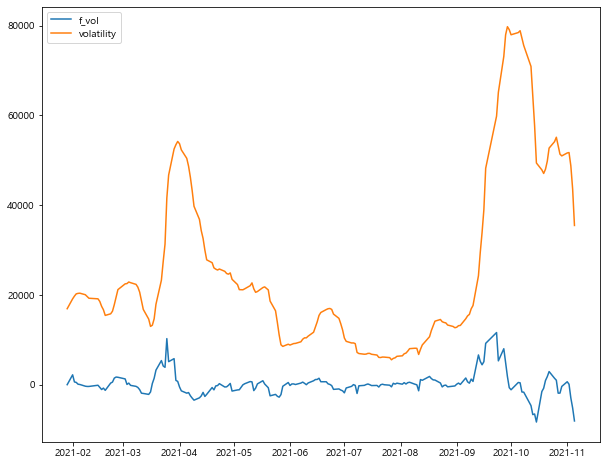

In [225]:
plt.figure(figsize=(10,8))
plt.plot(df1['f_vol'])
plt.plot(df1['volatility'])
plt.legend(['f_vol', 'volatility'])
plt.show()

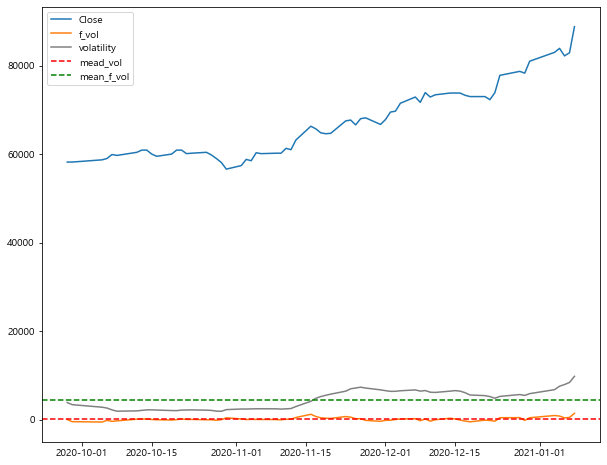

In [214]:
plt.figure(figsize=(10,8))
plt.plot(df1['Close'])
plt.plot(df1['f_vol'])
plt.plot(df1['volatility'], color='gray', linestyle='-')
plt.axhline(df1['f_vol'].mean(), color='red', linestyle='--')
plt.axhline(df1['volatility'].mean(), color='green', linestyle='--')
plt.legend(['Close', 'f_vol', 'volatility', 'mead_vol', 'mean_f_vol'])
plt.show()

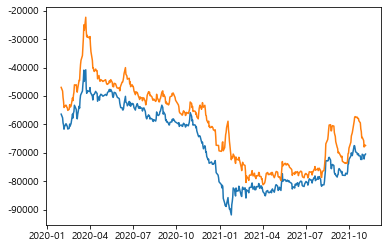

In [184]:
plt.plot(df1['f_vol'] - df1['Close'])
plt.plot(df1['volatility'] - df1['Close'])
plt.show()

In [185]:
from statsmodels.tsa.stattools import coint
score, pvalue, _ = coint(df1['f_vol'] - df1['Close'], df1['volatility'] - df1['Close'])
pvalue

0.0021313754537441304

In [186]:
score, pvalue, _ = coint(df1['f_vol'], df1['f_ma20'])
pvalue

1.7622632179035787e-09

In [187]:
score, pvalue, _ = coint(df1['f_vol'], df1['volatility'])
pvalue

2.8716988171819003e-09

In [188]:
score, pvalue, _ = coint(df1['f_vol'], df1['Close'])
pvalue

2.2511607528972333e-09

In [189]:
score, pvalue, _ = coint(df1['f_vol'], df1['f_ma20'])
pvalue

1.7622632179035787e-09

In [190]:
score, pvalue, _ = coint(df1['Close'], df1['f_close'])
pvalue

0.8849563263336255

In [191]:
score, pvalue, _ = coint(df1['ma20'], df1['f_ma20'])
pvalue

0.8588771891350611

In [192]:
df[(df['Close'] >= df['ma20']*1.03) & (df['Close'] < df['upper']*0.98)].shape[0] / df.shape[0]

0.0958904109589041

In [193]:
df[(df['Close'] >= df['ma20']*1.03) & (df['Close'] < df['ma20']*1.1)].shape

(83, 10)

In [194]:
tmp = df[(df['Close'] >= df['ma20']*1.03) & (df['Close'] < df['ma20']*1.1)].index
tmp

DatetimeIndex(['2020-04-07', '2020-04-09', '2020-04-10', '2020-04-14',
               '2020-04-16', '2020-04-17', '2020-04-20', '2020-05-29',
               '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
               '2020-06-08', '2020-06-09', '2020-06-10', '2020-06-11',
               '2020-07-06', '2020-07-15', '2020-07-21', '2020-07-27',
               '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31',
               '2020-08-03', '2020-08-04', '2020-08-06', '2020-08-11',
               '2020-08-12', '2020-08-13', '2020-09-08', '2020-09-09',
               '2020-09-10', '2020-09-11', '2020-09-14', '2020-09-15',
               '2020-09-16', '2020-09-17', '2020-09-18', '2020-11-13',
               '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
               '2020-11-27', '2020-11-30', '2020-12-01', '2020-12-02',
               '2020-12-03', '2020-12-04', '2020-12-07', '2020-12-08',
      